In [1]:
# set env LD_LIBRARY_PATH to install_path
install_path = "/Users/yumengxu/Project/Physics/cwb/cwb_source/tools/install/lib"

import os

os.environ['LD_LIBRARY_PATH'] = install_path
os.environ['HOME_WAT_FILTERS'] = '/usr/local/anaconda3/envs/cwb/lib/python3.11/site-packages/pycwb/shared'

from pycwb import logger_init
logger_init()

# load user parameters
from pycwb.config import Config, CWBConfig
# cwb_config = CWBConfig('./config.ini')
# cwb_config.export_to_envs()

config = Config('./user_parameters.yaml')
config.ifo

Welcome to JupyROOT 6.26/10


['L1', 'H1', 'V1']

In [2]:
# load noise from gwf
from pycwb.modules.read_data import read_from_gwf, generate_noise
# noise = [read_from_gwf(i, config, f"frames/L1H1V1-SimStrain-9311/{ifo}-SimStrain-931158100-600.gwf", config.channelNamesRaw[i], None, None ) for i, ifo in enumerate(config.ifo)]

noise = [generate_noise(f_low=30.0, sample_rate=1024.0, duration=600, start_time = 931158300, seed=i)
         for i, ifo in enumerate(config.ifo)]

2023-02-14 16:34:28,025 - pycwb.modules - INFO - WDM not found, loading wavelet library


In [3]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                         mass1=20,
                         mass2=20,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         distance=500,
                         delta_t=1.0/noise[0].sample_rate,
                         f_lower=20)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158400
from pycwb.modules.read_data import project_to_detector
strain = project_to_detector(hp, hc, right_ascension, declination, polarization, config.ifo, gps_end_time)

In [4]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp2, hc2 = get_td_waveform(approximant="IMRPhenomPv3",
                           mass1=20,
                           mass2=20,
                           spin1z=0.9,
                           spin2z=0.4,
                           inclination=1.23,
                           coa_phase=2.45,
                           distance=500,
                           delta_t=1.0/noise[0].sample_rate,
                           f_lower=20)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158390
from pycwb.modules.read_data import project_to_detector
strain2 = project_to_detector(hp2, hc2, right_ascension, declination, polarization, config.ifo, gps_end_time)

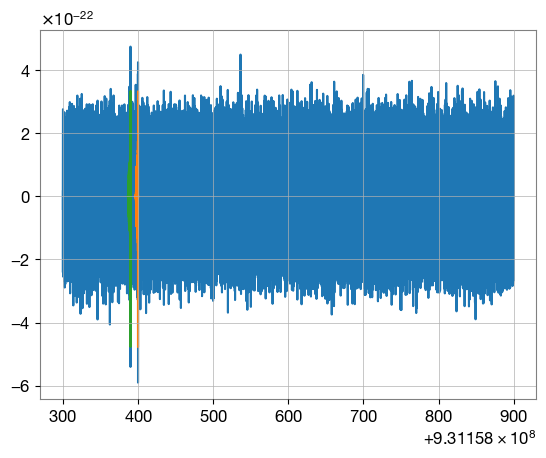

In [5]:
# inject signal into noise and convert to wavearray
injected = [noise[i].add_into(strain[i]) for i in range(len(config.ifo))]
injected = [injected[i].add_into(strain2[i]) for i in range(len(config.ifo))]
injected[0].plot()
strain[0].plot()
strain2[0].plot()

Filter length = 577,  norm = 0.9999999947541458


input_line_69:2:15: warning: instantiation of variable 'WDM<double>::Cos' required here, but no definition is available [-Wundefined-var-template]
 WDM<double>::Cos;
              ^
/Users/yumengxu/Project/Physics/cwb/cwb_source/wat/WDM.hh:137:19: note: forward declaration of template entity is here
   static double *Cos[MAXBETA], *Cos2[MAXBETA], *SinCos[MAXBETA];
                  ^
input_line_69:2:15: note: add an explicit instantiation declaration to suppress this warning if 'WDM<double>::Cos' is explicitly instantiated in another translation unit
 WDM<double>::Cos;
              ^
input_line_70:2:15: warning: instantiation of variable 'WDM<double>::Cos2' required here, but no definition is available [-Wundefined-var-template]
 WDM<double>::Cos2;
              ^
/Users/yumengxu/Project/Physics/cwb/cwb_source/wat/WDM.hh:137:34: note: forward declaration of template entity is here
   static double *Cos[MAXBETA], *Cos2[MAXBETA], *SinCos[MAXBETA];
                                 ^
inpu

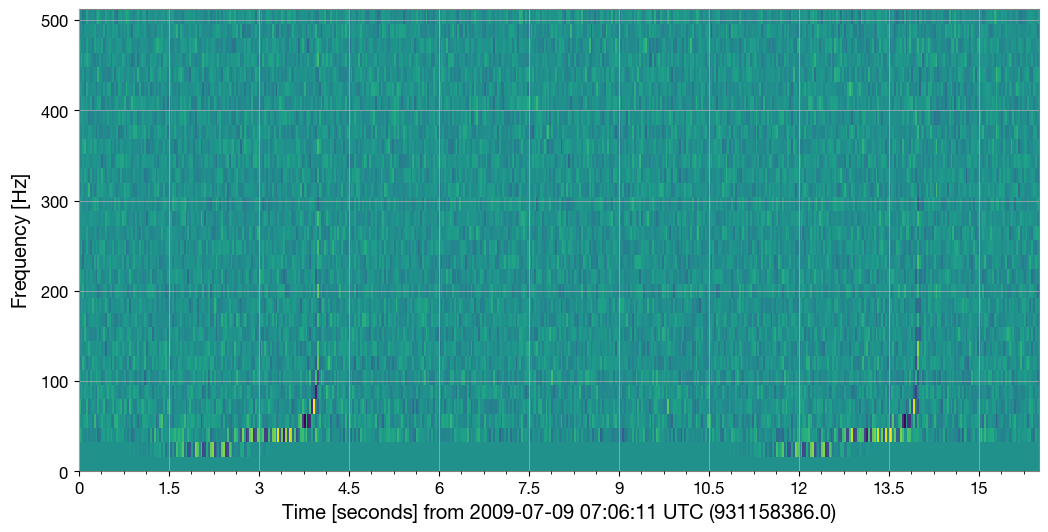

In [6]:
from pycwb.utils import convert_pycbc_timeseries_to_wavearray
wavearray = [convert_pycbc_timeseries_to_wavearray(d) for d in injected]

from pycwb.modules.plot import plot_spectrogram

plot_spectrogram(wavearray[0], xmin = gps_end_time-4, xmax = gps_end_time+12)

Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 577,  norm = 0.9999999947541458


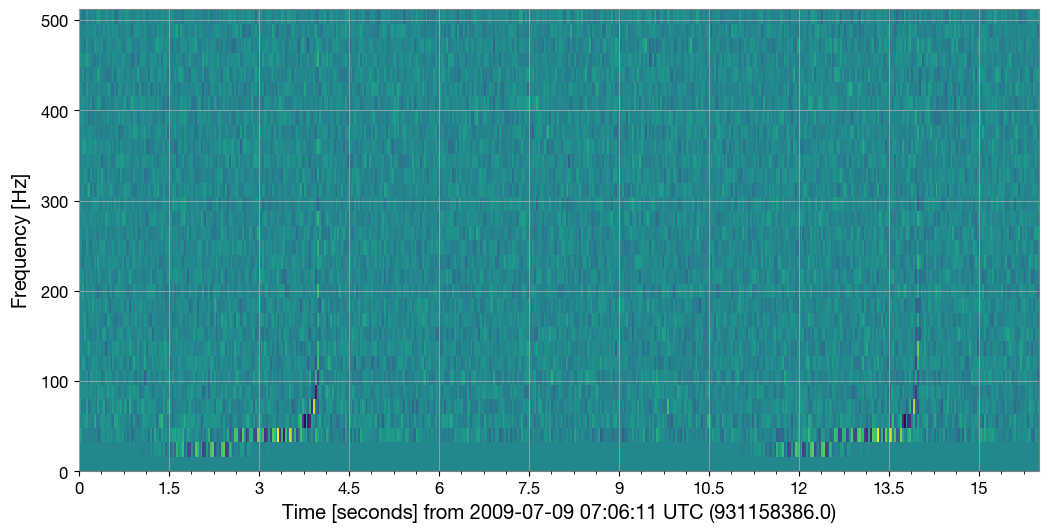

In [7]:
# data conditioning
from pycwb.modules.data_conditioning import regression, whitening
data_reg = [regression(config, wavearray[i]) for i in range(len(config.ifo))]

plot_spectrogram(data_reg[0], xmin = gps_end_time-4, xmax = gps_end_time+12)

2023-02-14 16:34:49,232 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-14 16:34:49,280 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-14 16:34:49,281 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-14 16:34:49,293 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-14 16:34:49,457 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-14 16:34:49,494 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-14 16:34:49,494 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-14 16:34:49,500 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-14 16:34:49,621 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-14 16:34:49,658 - pycwb.modules.data_conditioning.whitening - INFO - high pass filterin

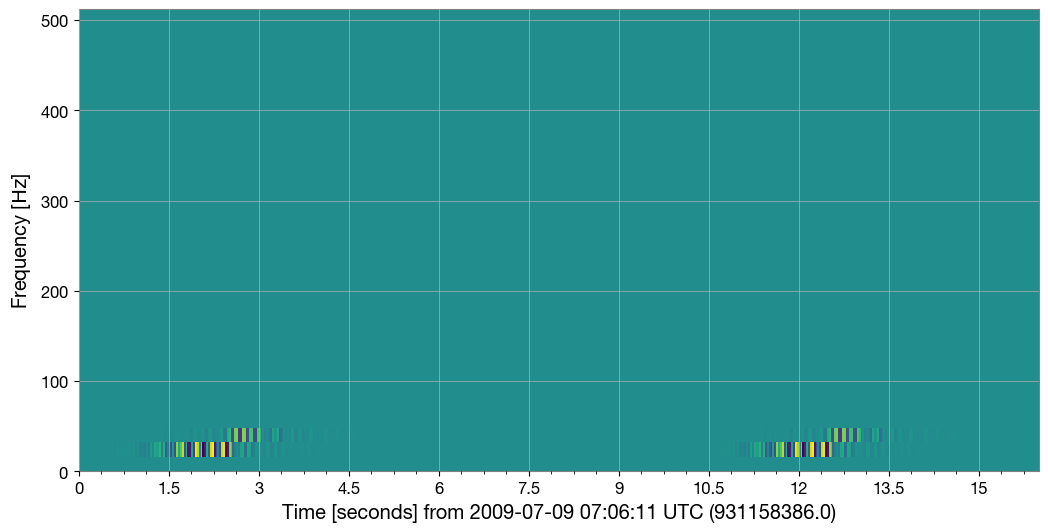

In [8]:
data_w_reg = [whitening(config, data_reg[i]) for i in range(len(config.ifo))]
tf_map = [d['TFmap'] for d in data_w_reg]

plot_spectrogram(data_w_reg[0]['TFmap'], xmin = gps_end_time-4, xmax = gps_end_time+12)

In [9]:
# initialize network
from pycwb.modules.coherence import create_network
net, wdm_list = create_network(1, config, data_w_reg)

2023-02-14 16:34:53,377 - pycwb.modules.coherence.network - INFO - Loading MRA
2023-02-14 16:34:53,459 - pycwb.modules.coherence.network - INFO - Filter length = 3.0009765625 (sec)
2023-02-14 16:34:53,583 - pycwb.modules.coherence.network - INFO - Filter length = 1.5009765625 (sec)
2023-02-14 16:34:53,631 - pycwb.modules.coherence.network - INFO - Filter length = 0.7509765625 (sec)
2023-02-14 16:34:53,679 - pycwb.modules.coherence.network - INFO - Filter length = 0.3759765625 (sec)
2023-02-14 16:34:53,729 - pycwb.modules.coherence.network - INFO - Filter length = 0.1884765625 (sec)
2023-02-14 16:34:53,781 - pycwb.modules.coherence.network - INFO - Filter length = 0.0947265625 (sec)
2023-02-14 16:34:53,782 - pycwb.modules.coherence.network - INFO - Initializing network
2023-02-14 16:34:53,782 - pycwb.modules.coherence.network - INFO - Adding ifo L1
2023-02-14 16:34:53,809 - pycwb.modules.coherence.network - INFO - Adding ifo H1
2023-02-14 16:34:53,814 - pycwb.modules.coherence.network -

(931158386.0, 931158402.0)

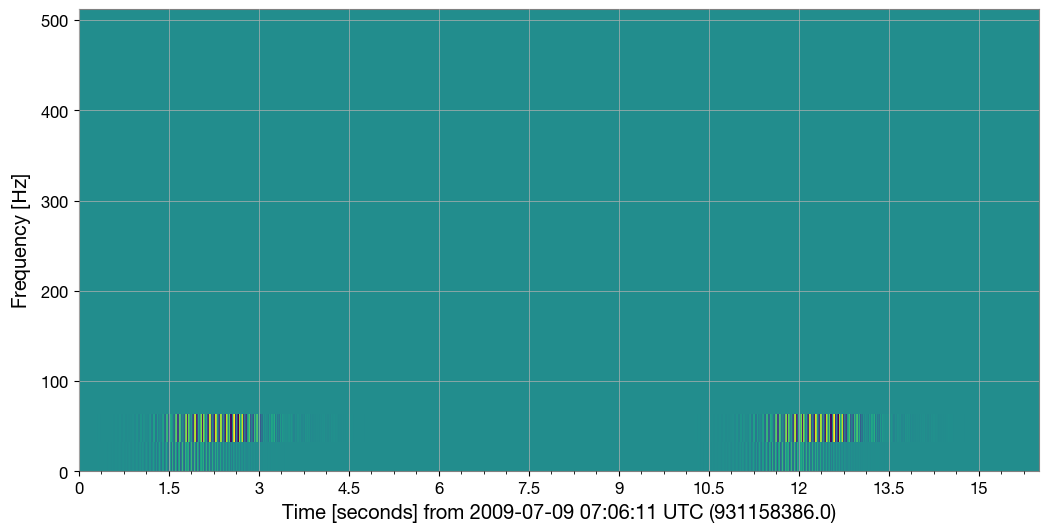

In [10]:
import ROOT
import numpy as np
from pycwb.utils import WSeries_to_matrix
from gwpy.spectrogram import Spectrogram

tf_map_p = ROOT.WSeries(np.double)(data_w_reg[0]['TFmap'], wdm_list[4])
tf_map_p.Forward()

plot = Spectrogram(WSeries_to_matrix(tf_map_p).T,
                   t0=tf_map_p.start(),
                   dt=1/tf_map_p.wRate,
                   f0=tf_map_p.f_low,
                   df=tf_map_p.resolution()
                   ).plot()
ax = plot.gca()
xmin = gps_end_time-4
xmax = gps_end_time+12
ax.set_xlim(xmin, xmax)

In [13]:
## select pixels
from pycwb.modules.coherence import select_pixels
sparse_table_list, cluster_list = select_pixels(config, net, tf_map, wdm_list)

2023-02-14 16:37:59,182 - pycwb.modules.coherence.coherence - INFO - thresholds in units of noise variance: Eo=10.8347 Emax=21.6694
2023-02-14 16:37:59,183 - pycwb.modules.coherence.coherence - INFO - cwb2G::Coherence -RES:0-THR:10.8346991157288
2023-02-14 16:37:59,185 - pycwb.modules.coherence.coherence - INFO - live time in zero lag: 584
2023-02-14 16:37:59,254 - pycwb.modules.coherence.coherence - INFO - lag|clusters|pixels 
2023-02-14 16:37:59,263 - pycwb.modules.coherence.coherence - INFO -   0|        8|    109 
2023-02-14 16:38:01,914 - pycwb.modules.coherence.coherence - INFO - thresholds in units of noise variance: Eo=12.897 Emax=25.794
2023-02-14 16:38:01,915 - pycwb.modules.coherence.coherence - INFO - cwb2G::Coherence -RES:1-THR:12.896985523276378
2023-02-14 16:38:01,918 - pycwb.modules.coherence.coherence - INFO - live time in zero lag: 584
2023-02-14 16:38:01,981 - pycwb.modules.coherence.coherence - INFO - lag|clusters|pixels 
2023-02-14 16:38:01,988 - pycwb.modules.cohe

In [14]:
from pycwb.modules.super_cluster import supercluster

supercluster(config, net, wdm_list, cluster_list, sparse_table_list)

2023-02-14 16:39:16,578 - pycwb.modules.coherence.network - INFO - Setting skymaps
2023-02-14 16:39:16,584 - pycwb.modules.coherence.network - INFO - Setting sky mask
2023-02-14 16:39:16,597 - pycwb.modules.super_cluster.supercluster - INFO - -> Processing lag=0 ...
2023-02-14 16:39:16,597 - pycwb.modules.super_cluster.supercluster - INFO -    --------------------------------------------------
2023-02-14 16:39:16,598 - pycwb.modules.super_cluster.supercluster - INFO -    coher  clusters|pixels      :     13|807
2023-02-14 16:39:16,599 - pycwb.modules.super_cluster.supercluster - INFO - super clusters|pixels      :      2|203
2023-02-14 16:39:16,632 - pycwb.modules.super_cluster.supercluster - INFO -    subnet clusters|pixels      :      2|203
2023-02-14 16:39:16,633 - pycwb.modules.super_cluster.supercluster - INFO - defrag clusters|pixels      :      2|203
2023-02-14 16:39:16,633 - pycwb.modules.super_cluster.supercluster - INFO - Supercluster done
2023-02-14 16:39:16,633 - pycwb.modu